In [346]:
# pip install beautifulsoup4    # Download and install beautiful soup 4
# pip install lxml              # Download and install lxml for its XML and HTML parser
# pip install requests          # Download and install Python requests module
# pip install seaborn           # Download and install Seaborn for visualizations

from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

import requests
import sys
import re

import sklearn
import sklearn.cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# from pyspark import SparkConf, SparkContext, SQLContext
# from pyspark.sql.types import *
#
# conf = SparkConf().setAppName('Project')
# sc = SparkContext(conf=conf)
# sqlContext = SQLContext(sc)

money_control_root = 'http://www.moneycontrol.com'

In [2]:
# Get 10 mutual fund families with the highest Assets under Management from Money Control
markup = requests.get(money_control_root + '/mutual-funds/amc-assets-monitor').text

# make the soup
soup = BeautifulSoup(markup, "lxml")

# the table that contains the required data
table = soup.find_all('table', attrs = {"class": "tblfund1"})[0]

# get the first ten rows in this table, excluding
# the first row as it has only header information
rows = table.find_all('tr')[1:11]


# fund_families_schema = StructType([
#     StructField("fund_family", StringType(), True),
#     StructField("fund_family_url", StringType(), True),
#     StructField("fund_family_aum", StringType(), True)
# ])

# Fund Family and Assets under Management (Rs. Cr.) for the top 10 mutual fund families
fund_families = []
for r in rows:
    ff_dict = {
        'fund_family_name': unicode( r.contents[1].a.string ),
        'fund_family_url' : unicode( money_control_root + r.contents[1].a.attrs['href'] ),
        'fund_family_aum' : unicode( r.contents[5].string ),
        'fund_family_shortcode' : unicode( money_control_root + r.contents[1].a.attrs['href'] ).split('/')[-1]
    }
    
    fund_families.append( ff_dict )

In [3]:
print( fund_families )

[{'fund_family_aum': u'178,373', 'fund_family_name': u'HDFC Mutual Fund', 'fund_family_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', 'fund_family_shortcode': u'HD'}, {'fund_family_aum': u'172,154', 'fund_family_name': u'ICICI Prudential Mutual Fund', 'fund_family_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/PI', 'fund_family_shortcode': u'PI'}, {'fund_family_aum': u'156,948', 'fund_family_name': u'Reliance Mutual Fund', 'fund_family_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/RC', 'fund_family_shortcode': u'RC'}, {'fund_family_aum': u'136,561', 'fund_family_name': u'Birla Sun Life Mutual Fund', 'fund_family_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/BS', 'fund_family_shortcode': u'BS'}, {'fund_family_aum': u'106,129', 'fund_family_name': u'UTI Mutual Fund', 'fund_family_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/UT', 'fund_family_shortcode': u'UT'}, {'fund_family_aum': u'100,055', 'fund_family_name

In [284]:
# For each fund family, get a list of all fund schemes along with other details
fund_schemes = []
for fund in fund_families:
    
    markup = requests.get( fund['fund_family_url'] ).text

    soup = BeautifulSoup(markup, "lxml")

    rows = soup.select('.FL.MT10.boxBg table tr')[1:-1]
    
    for r in rows:
        data_elems      = r.find_all('td')
    
        category_name   = ''
        scheme_aum      = ''
        category_url    = ''
        
        try:
            category_name   = unicode( data_elems[2].a.string )
            category_url    = money_control_root + data_elems[2].a.attrs['href']
            
        except AttributeError:
            category_name   = u'None'
            category_url    = u'None'
    
        try:
            scheme_aum = unicode( data_elems[5].string )
        except AttributeError:
            scheme_aum = u'None'

        fscheme_dict    = {
            'fund_family_name'      : fund['fund_family_name'],
            'fund_family_url'       : fund['fund_family_url' ],
            'fund_family_aum'       : fund['fund_family_aum' ],
            'fund_family_shortcode' : fund['fund_family_shortcode'],
            'scheme_name'           : unicode( data_elems[0].a.string ),
            'scheme_url'            : money_control_root + data_elems[0].a.attrs['href'],
            'crisil_rating'         : unicode( data_elems[1].a.string ),
            'category'              : category_name,
            'category_url'          : category_url,
            'latest_nav'            : unicode( data_elems[3].string ),
            '1yr_return'            : u'None' if unicode( data_elems[4].string ) == u'--' else unicode( data_elems[4].string ),
            'scheme_aum'            : scheme_aum
        }

        fund_schemes.append( fscheme_dict )

In [285]:
print( len( fund_schemes ), '\n\n', fund_schemes[:10])

(1296, '\n\n', [{'fund_family_aum': u'178,373', 'fund_family_shortcode': u'HD', 'scheme_url': 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-arbitrage-fund-direct-plan/MHD1171', 'latest_nav': u'18.40', 'fund_family_name': u'HDFC Mutual Fund', 'fund_family_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', 'category': u'Arbitrage & Arbitrage Plus', 'scheme_name': u'HDFC Arbitrage Fund - Direct (G)', 'scheme_aum': u'3.67', '1yr_return': u'7.3', 'category_url': 'http://www.moneycontrol.com/mutual-funds/performance-tracker/returns/arbitrage-and-arbitrage-plus.html', 'crisil_rating': u'Not Ranked'}, {'fund_family_aum': u'178,373', 'fund_family_shortcode': u'HD', 'scheme_url': 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-arbitrage-fund-retail-plan/MHD225', 'latest_nav': u'18.19', 'fund_family_name': u'HDFC Mutual Fund', 'fund_family_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', 'category': u'Arbitrage & Arbitrage Plus', 'scheme_name': u'HDFC Arbit

In [286]:
for idx, scheme in enumerate(fund_schemes):
    # Read the page at the URL for each scheme
    markup = requests.get( scheme['scheme_url'] ).text
    soup = BeautifulSoup(markup, "lxml")


    # Riskometer (Risk Rating)
    scheme['scheme_risk_text'] = unicode(soup.select('.header .MT10 .toplft_cl3 p.avgbgtit')[0].string )

    # Scheme Plan and Scheme Option
    scheme_plan_option_data    = [unicode( x.string ).strip() for x in soup.select('#planname_frm .FL span')]
    
    [scheme['scheme_plan'],
     scheme['scheme_option'] ] = scheme_plan_option_data if scheme_plan_option_data else [u'None', u'None']


    # From the Investment Info section, collect scheme fund type,
    # benchmark name, minimum investment required for this scheme,
    # last dividend or bonus, if paid else NA
    sub_soup = soup.select('.mainCont .tog_cont .MT20 .FL td')
    [scheme['scheme_fund_type'],
     scheme['scheme_benchmark'],
     scheme['scheme_min_investment'],
     scheme['scheme_last_dividend'],
     scheme['scheme_bonus'] ] = [
        unicode(x.string).strip() if( x.string and unicode(x.string).strip() != u'N.A.' ) else u'None' for x in [
            sub_soup[0],
            sub_soup[3],
            sub_soup[5],
            sub_soup[6],
            sub_soup[7]
        ]
    ]



    # From the performance section, gather
    # Fund Returns, Category Avg, Difference of Fund Returns and Category Returns
    # Best of category and worst of category
    sub_soup = soup.select('.mainCont .tog_cont table')[0]

    # Get the relevant table rows containing this information
    rows = [row for row in sub_soup if not row.string and unicode(row).strip()][1:]

    for row in rows:
        row_attrs = [x for x in row.children if unicode(x).strip()]

        row_name  = unicode(row_attrs[0].string).strip().lower()

        # fund returns
        if row_name == 'fund returns':
            scheme['fund_ret_1m']      = u'None' if unicode( row_attrs[1].string ) == u'--' else unicode( row_attrs[1].string )
            scheme['fund_ret_3m']      = u'None' if unicode( row_attrs[2].string ) == u'--' else unicode( row_attrs[2].string )
            scheme['fund_ret_6m']      = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
            scheme['fund_ret_1y']      = u'None' if unicode( row_attrs[4].string ) == u'--' else unicode( row_attrs[4].string )
            scheme['fund_ret_2y']      = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
            scheme['fund_ret_3y']      = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )
            scheme['fund_ret_5y']      = u'None' if unicode( row_attrs[7].string ) == u'--' else unicode( row_attrs[7].string )

        # category avg
        if row_name == 'category avg':
            scheme['cat_avg_ret_1m']   = u'None' if unicode( row_attrs[1].string ) == u'--' else unicode( row_attrs[1].string )
            scheme['cat_avg_ret_3m']   = u'None' if unicode( row_attrs[2].string ) == u'--' else unicode( row_attrs[2].string )
            scheme['cat_avg_ret_6m']   = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
            scheme['cat_avg_ret_1y']   = u'None' if unicode( row_attrs[4].string ) == u'--' else unicode( row_attrs[4].string )
            scheme['cat_avg_ret_2y']   = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
            scheme['cat_avg_ret_3y']   = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )
            scheme['cat_avg_ret_5y']   = u'None' if unicode( row_attrs[7].string ) == u'--' else unicode( row_attrs[7].string )

        # difference of fund returns and category returns
        if row_name == 'difference of fund returns and category returns':
            scheme['diff_fund_cat_1m'] = u'None' if unicode( row_attrs[1].string ) == u'--' else unicode( row_attrs[1].string )
            scheme['diff_fund_cat_3m'] = u'None' if unicode( row_attrs[2].string ) == u'--' else unicode( row_attrs[2].string )
            scheme['diff_fund_cat_6m'] = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
            scheme['diff_fund_cat_1y'] = u'None' if unicode( row_attrs[4].string ) == u'--' else unicode( row_attrs[4].string )
            scheme['diff_fund_cat_2y'] = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
            scheme['diff_fund_cat_3y'] = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )
            scheme['diff_fund_cat_5y'] = u'None' if unicode( row_attrs[7].string ) == u'--' else unicode( row_attrs[7].string )

        # best of category
        if row_name == 'best of category':
            scheme['cat_best_1m']      = u'None' if unicode( row_attrs[1].string ) == u'--' else unicode( row_attrs[1].string )
            scheme['cat_best_3m']      = u'None' if unicode( row_attrs[2].string ) == u'--' else unicode( row_attrs[2].string )
            scheme['cat_best_6m']      = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
            scheme['cat_best_1y']      = u'None' if unicode( row_attrs[4].string ) == u'--' else unicode( row_attrs[4].string )
            scheme['cat_best_2y']      = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
            scheme['cat_best_3y']      = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )
            scheme['cat_best_5y']      = u'None' if unicode( row_attrs[7].string ) == u'--' else unicode( row_attrs[7].string )

        # worst of category
        if row_name == 'worst of category':
            scheme['cat_worst_1m']     = u'None' if unicode( row_attrs[1].string ) == u'--' else unicode( row_attrs[1].string )
            scheme['cat_worst_3m']     = u'None' if unicode( row_attrs[2].string ) == u'--' else unicode( row_attrs[2].string )
            scheme['cat_worst_6m']     = u'None' if unicode( row_attrs[3].string ) == u'--' else unicode( row_attrs[3].string )
            scheme['cat_worst_1y']     = u'None' if unicode( row_attrs[4].string ) == u'--' else unicode( row_attrs[4].string )
            scheme['cat_worst_2y']     = u'None' if unicode( row_attrs[5].string ) == u'--' else unicode( row_attrs[5].string )
            scheme['cat_worst_3y']     = u'None' if unicode( row_attrs[6].string ) == u'--' else unicode( row_attrs[6].string )
            scheme['cat_worst_5y']     = u'None' if unicode( row_attrs[7].string ) == u'--' else unicode( row_attrs[7].string )

    # Print every 100th scheme to verify things are running smoothly
    if idx % 100 == 0:
        print( 'Scheme # {0}\n{1}\n\n\n'.format(idx, scheme) )
    else:
        print idx, ' ',


Scheme # 0
{'fund_family_aum': u'178,373', 'fund_family_shortcode': u'HD', 'scheme_plan': u'Direct', 'scheme_risk_text': u'MODERATELY LOW', 'fund_family_url': u'http://www.moneycontrol.com/mutual-funds/amc-details/HD', 'cat_best_6m': u'4.0', 'diff_fund_cat_1y': u'1.2', 'cat_avg_ret_3y': u'6.1', 'cat_avg_ret_3m': u'1.4', 'diff_fund_cat_1m': u'-0.1', 'diff_fund_cat_5y': u'None', 'cat_worst_1m': u'0.4', 'cat_worst_1y': u'5.5', 'latest_nav': u'18.40', 'scheme_last_dividend': u'None', 'scheme_min_investment': u'Rs.5000', 'diff_fund_cat_6m': u'0.5', 'fund_ret_3y': u'8.0', 'fund_ret_2y': u'7.7', 'cat_worst_5y': u'7.7', 'cat_best_5y': u'8.8', '1yr_return': u'7.3', 'category_url': 'http://www.moneycontrol.com/mutual-funds/performance-tracker/returns/arbitrage-and-arbitrage-plus.html', 'cat_best_1m': u'1.7', 'diff_fund_cat_2y': u'2.0', 'cat_avg_ret_2y': u'5.7', 'fund_ret_6m': u'3.2', 'cat_best_1y': u'8.2', 'cat_worst_6m': u'2.4', 'scheme_bonus': u'None', 'scheme_benchmark': u'CRISIL Liquid Fund'

In [208]:
#Save the collected data to text, which is then converted to a csv file.
import csv
out_path= "./fund_schemes.txt"
out_file = open(out_path, 'wb')

fieldnames = sorted(list(set(k for d in fund_schemes for k in d)))
writer = csv.DictWriter(out_file, fieldnames=fieldnames, dialect='excel')

writer.writeheader() # Assumes Python >= 2.7
for row in fund_schemes:
    writer.writerow(row)
out_file.close()

In [270]:
'''
Method to convert risk text to a numerical attribute
'''
def encode_risk(risk_text):
    # The higher the risk, the lower the score!
    risk = {
        u'HIGH'              :  1,
        u'MODERATELY HIGH'   :  2,
        u'MODERATE'          :  3,
        u'MODERATELY LOW'    :  4,
        u'LOW'               :  5 
    }
    try:
        return risk[ unicode( risk_text.upper() ) ]
    except:
        return 0

'''
Method to convert numerical features that appear as strings or unicode strings into numbers
'''
def to_numeric( text ):
    try:
        return float( re.sub(
            '(Rs[ ]*\.)|[^\d|.|-]|(Rank[ ]*)',
            '',
            text,
            flags = re.IGNORECASE
        ) )
    except:
        return None

In [326]:
# Processing for ML

# Initialize a list to store metrics for ris
for idx, scheme in enumerate( fund_schemes ):
    ##
    # Step 1: Convert numerical features appearing as text to numerical features
    #         1.a: Encode risk text to a numerical representation of risk.
    #              Highest risk gets the lowest score, lowest risk gets the highest score
    #
    #         1.b: Convert numbers formatted with commas or currency or rating description to just numbers
    ##
    
    # Convert scheme risk text to a numerical attribute
    fund_schemes[idx]['num_scheme_risk']            = encode_risk( scheme['scheme_risk_text'] )
    
    # Convert metrics to numerical features
    fund_schemes[idx]['num_fund_family_aum']        = to_numeric( scheme['fund_family_aum'] )

    fund_schemes[idx]['num_crisil_rating']          = to_numeric( scheme['crisil_rating'] )

    fund_schemes[idx]['num_latest_nav']             = to_numeric( scheme['latest_nav'] )
    fund_schemes[idx]['num_1yr_return']             = to_numeric( scheme['1yr_return'] )
    fund_schemes[idx]['num_scheme_aum']             = to_numeric( scheme['scheme_aum'] ) if scheme['scheme_aum'] != u'None' else 0

    fund_schemes[idx]['num_scheme_min_investment']  = to_numeric( scheme['scheme_min_investment'] )
    fund_schemes[idx]['num_scheme_last_dividend']   = to_numeric( scheme['scheme_last_dividend'] )
    fund_schemes[idx]['num_scheme_bonus']           = to_numeric( scheme['scheme_bonus'] )

    fund_schemes[idx]['num_fund_ret_1m']            = to_numeric( scheme['fund_ret_1m'] )
    fund_schemes[idx]['num_fund_ret_3m']            = to_numeric( scheme['fund_ret_3m'] )
    fund_schemes[idx]['num_fund_ret_6m']            = to_numeric( scheme['fund_ret_6m'] )
    fund_schemes[idx]['num_fund_ret_1y']            = to_numeric( scheme['fund_ret_1y'] )
    fund_schemes[idx]['num_fund_ret_2y']            = to_numeric( scheme['fund_ret_2y'] )
    fund_schemes[idx]['num_fund_ret_3y']            = to_numeric( scheme['fund_ret_3y'] )
    fund_schemes[idx]['num_fund_ret_5y']            = to_numeric( scheme['fund_ret_5y'] )

    fund_schemes[idx]['num_cat_avg_ret_1m']         = to_numeric( scheme['cat_avg_ret_1m'] )
    fund_schemes[idx]['num_cat_avg_ret_3m']         = to_numeric( scheme['cat_avg_ret_3m'] )
    fund_schemes[idx]['num_cat_avg_ret_6m']         = to_numeric( scheme['cat_avg_ret_6m'] )
    fund_schemes[idx]['num_cat_avg_ret_1y']         = to_numeric( scheme['cat_avg_ret_1y'] )
    fund_schemes[idx]['num_cat_avg_ret_2y']         = to_numeric( scheme['cat_avg_ret_2y'] )
    fund_schemes[idx]['num_cat_avg_ret_3y']         = to_numeric( scheme['cat_avg_ret_3y'] )
    fund_schemes[idx]['num_cat_avg_ret_5y']         = to_numeric( scheme['cat_avg_ret_5y'] )

    fund_schemes[idx]['num_diff_fund_cat_1m']       = to_numeric( scheme['diff_fund_cat_1m'] )
    fund_schemes[idx]['num_diff_fund_cat_3m']       = to_numeric( scheme['diff_fund_cat_3m'] )
    fund_schemes[idx]['num_diff_fund_cat_6m']       = to_numeric( scheme['diff_fund_cat_6m'] )
    fund_schemes[idx]['num_diff_fund_cat_1y']       = to_numeric( scheme['diff_fund_cat_1y'] )
    fund_schemes[idx]['num_diff_fund_cat_2y']       = to_numeric( scheme['diff_fund_cat_2y'] )
    fund_schemes[idx]['num_diff_fund_cat_3y']       = to_numeric( scheme['diff_fund_cat_3y'] )
    fund_schemes[idx]['num_diff_fund_cat_5y']       = to_numeric( scheme['diff_fund_cat_5y'] )

    fund_schemes[idx]['num_cat_best_1m']            = to_numeric( scheme['cat_best_1m'] )
    fund_schemes[idx]['num_cat_best_3m']            = to_numeric( scheme['cat_best_3m'] )
    fund_schemes[idx]['num_cat_best_6m']            = to_numeric( scheme['cat_best_6m'] )
    fund_schemes[idx]['num_cat_best_1y']            = to_numeric( scheme['cat_best_1y'] )
    fund_schemes[idx]['num_cat_best_2y']            = to_numeric( scheme['cat_best_2y'] )
    fund_schemes[idx]['num_cat_best_3y']            = to_numeric( scheme['cat_best_3y'] )
    fund_schemes[idx]['num_cat_best_5y']            = to_numeric( scheme['cat_best_5y'] )

    fund_schemes[idx]['num_cat_worst_1m']           = to_numeric( scheme['cat_worst_1m'] )
    fund_schemes[idx]['num_cat_worst_3m']           = to_numeric( scheme['cat_worst_3m'] )
    fund_schemes[idx]['num_cat_worst_6m']           = to_numeric( scheme['cat_worst_6m'] )
    fund_schemes[idx]['num_cat_worst_1y']           = to_numeric( scheme['cat_worst_1y'] )
    fund_schemes[idx]['num_cat_worst_2y']           = to_numeric( scheme['cat_worst_2y'] )
    fund_schemes[idx]['num_cat_worst_3y']           = to_numeric( scheme['cat_worst_3y'] )
    fund_schemes[idx]['num_cat_worst_5y']           = to_numeric( scheme['cat_worst_5y'] )
    
    
    ##
    # Step 2: Calculate additional risk metrics - the fetched risk rating is based on MPT Statistics
    #         which is already a sound measurement. Hence, we devise and incorporate more measures
    #         such as:
    ##
    
    # Score between 0 and 1 based on Risk Rating which is based on MPT Statistics
    fund_schemes[idx]['cstm_mtrc_risk_rating'] = fund_schemes[idx]['num_scheme_risk'] / 5.0
    
    # Score between 0 and 1 based on CRISIL rating
    fund_schemes[idx]['cstm_mtrc_crisil']  = fund_schemes[idx]['num_crisil_rating'] / 5.0 if fund_schemes[idx]['num_crisil_rating'] else 0
    
    # Score between 0 and 1 based on AUM allocation to the scheme compared to other schemes in the fund family
    fund_schemes[idx]['cstm_mtrc_alloc'] = float( fund_schemes[idx]['num_scheme_aum'] ) / ( fund_schemes[idx]['num_fund_family_aum'] - fund_schemes[idx]['num_scheme_aum'] )
    
    # Score between 0 and 1 based on fund performance relative to category performance
    fund_schemes[idx]['cstm_mtrc_diff_1m'] = 1 if fund_schemes[idx]['num_diff_fund_cat_1m'] and fund_schemes[idx]['num_diff_fund_cat_1m'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_3m'] = 1 if fund_schemes[idx]['num_diff_fund_cat_3m'] and fund_schemes[idx]['num_diff_fund_cat_3m'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_6m'] = 1 if fund_schemes[idx]['num_diff_fund_cat_6m'] and fund_schemes[idx]['num_diff_fund_cat_6m'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_1y'] = 1 if fund_schemes[idx]['num_diff_fund_cat_1y'] and fund_schemes[idx]['num_diff_fund_cat_1y'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_2y'] = 1 if fund_schemes[idx]['num_diff_fund_cat_2y'] and fund_schemes[idx]['num_diff_fund_cat_2y'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_3y'] = 1 if fund_schemes[idx]['num_diff_fund_cat_3y'] and fund_schemes[idx]['num_diff_fund_cat_3y'] > 0 else 0
    fund_schemes[idx]['cstm_mtrc_diff_5y'] = 1 if fund_schemes[idx]['num_diff_fund_cat_5y'] and fund_schemes[idx]['num_diff_fund_cat_5y'] > 0 else 0
    
    # Score between 0 and 1 based on volatility in fund's category
    fund_schemes[idx]['cstm_mtrc_volat_1m'] = float( fund_schemes[idx]['num_cat_worst_1m'] ) / fund_schemes[idx]['num_cat_best_1m'] if fund_schemes[idx]['num_cat_worst_1m'] and fund_schemes[idx]['num_cat_worst_1m'] >= 0 else 0
    fund_schemes[idx]['cstm_mtrc_volat_3m'] = float( fund_schemes[idx]['num_cat_worst_3m'] ) / fund_schemes[idx]['num_cat_best_3m'] if fund_schemes[idx]['num_cat_worst_3m'] and fund_schemes[idx]['num_cat_worst_3m'] >= 0 else 0
    fund_schemes[idx]['cstm_mtrc_volat_6m'] = float( fund_schemes[idx]['num_cat_worst_6m'] ) / fund_schemes[idx]['num_cat_best_6m'] if fund_schemes[idx]['num_cat_worst_6m'] and fund_schemes[idx]['num_cat_worst_6m'] >= 0 else 0
    fund_schemes[idx]['cstm_mtrc_volat_1y'] = float( fund_schemes[idx]['num_cat_worst_1y'] ) / fund_schemes[idx]['num_cat_best_1y'] if fund_schemes[idx]['num_cat_worst_1y'] and fund_schemes[idx]['num_cat_worst_1y'] >= 0 else 0
    fund_schemes[idx]['cstm_mtrc_volat_2y'] = float( fund_schemes[idx]['num_cat_worst_2y'] ) / fund_schemes[idx]['num_cat_best_2y'] if fund_schemes[idx]['num_cat_worst_2y'] and fund_schemes[idx]['num_cat_worst_2y'] >= 0 else 0
    fund_schemes[idx]['cstm_mtrc_volat_3y'] = float( fund_schemes[idx]['num_cat_worst_3y'] ) / fund_schemes[idx]['num_cat_best_3y'] if fund_schemes[idx]['num_cat_worst_3y'] and fund_schemes[idx]['num_cat_worst_3y'] >= 0 else 0
    fund_schemes[idx]['cstm_mtrc_volat_5y'] = float( fund_schemes[idx]['num_cat_worst_5y'] ) / fund_schemes[idx]['num_cat_best_5y'] if fund_schemes[idx]['num_cat_worst_5y'] and fund_schemes[idx]['num_cat_worst_5y'] >= 0 else 0
    
    
    
    # Initialize a set of lists to contain class labels based on time frame
    normal_scores_1m = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_1m'],
        fund_schemes[idx]['cstm_mtrc_volat_1m']
    ]
    
    normal_scores_3m = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_3m'],
        fund_schemes[idx]['cstm_mtrc_volat_3m']
    ]
    
    normal_scores_6m = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_6m'],
        fund_schemes[idx]['cstm_mtrc_volat_6m']
    ]
    
    normal_scores_1y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_1y'],
        fund_schemes[idx]['cstm_mtrc_volat_1y']
    ]
    
    normal_scores_2y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_2y'],
        fund_schemes[idx]['cstm_mtrc_volat_2y']
    ]
    
    normal_scores_3y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_3y'],
        fund_schemes[idx]['cstm_mtrc_volat_3y']
    ]
    
    normal_scores_5y = [
        fund_schemes[idx]['cstm_mtrc_risk_rating'],
        fund_schemes[idx]['cstm_mtrc_crisil'],
        fund_schemes[idx]['cstm_mtrc_alloc'],
        fund_schemes[idx]['cstm_mtrc_diff_5y'],
        fund_schemes[idx]['cstm_mtrc_volat_5y']
    ]
    
    
    ##
    # Calculate labels for each time frame based on calculated metrics
    ## 
    ##
    labels_1m = round( float( sum(normal_scores_1m ) ) / max( len( normal_scores_1m ), 1 ) )
    labels_3m = round( float( sum(normal_scores_3m ) ) / max( len( normal_scores_3m ), 1 ) )
    labels_6m = round( float( sum(normal_scores_6m ) ) / max( len( normal_scores_6m ), 1 ) )
    labels_1y = round( float( sum(normal_scores_1y ) ) / max( len( normal_scores_1y ), 1 ) )
    labels_2y = round( float( sum(normal_scores_2y ) ) / max( len( normal_scores_2y ), 1 ) )
    labels_3y = round( float( sum(normal_scores_3y ) ) / max( len( normal_scores_3y ), 1 ) )
    labels_5y = round( float( sum(normal_scores_5y ) ) / max( len( normal_scores_5y ), 1 ) )

    # Store the labels for each time frame along with scheme details
    fund_schemes[idx]['calculated_label_1m'] = labels_1m
    fund_schemes[idx]['calculated_label_3m'] = labels_3m
    fund_schemes[idx]['calculated_label_6m'] = labels_6m
    fund_schemes[idx]['calculated_label_1y'] = labels_1y
    fund_schemes[idx]['calculated_label_2y'] = labels_2y
    fund_schemes[idx]['calculated_label_3y'] = labels_3y
    fund_schemes[idx]['calculated_label_5y'] = labels_5y



In [328]:
some_val = list()
for scheme in fund_schemes:
    if scheme['num_crisil_rating'] not in some_val:
        some_val.append( scheme['num_crisil_rating'] )
    
print set( some_val )

set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])


In [ ]:
import csv

keys = toCSV[0].keys()
with open('funds.csv', 'wb') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(toCSV)

In [307]:
##
# Create target values for each time frame
##
Y_1m = np.array( [scheme['calculated_label_1m'] for scheme in fund_schemes] )
Y_3m = np.array( [scheme['calculated_label_3m'] for scheme in fund_schemes] )
Y_6m = np.array( [scheme['calculated_label_6m'] for scheme in fund_schemes] )
Y_1y = np.array( [scheme['calculated_label_1y'] for scheme in fund_schemes] )
Y_2y = np.array( [scheme['calculated_label_2y'] for scheme in fund_schemes] )
Y_3y = np.array( [scheme['calculated_label_3y'] for scheme in fund_schemes] )
Y_5y = np.array( [scheme['calculated_label_5y'] for scheme in fund_schemes] )


(array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([ 1.,  1.,  1., ...,  0.,  0.,  0.]), array([ 0.,  1.,  1., ...,  0.,  0.,  0.]))


In [422]:
##
# Create feature vectors for each time frame
##
X_1m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_scheme_min_investment'] if scheme['num_scheme_min_investment'] else 0,
            scheme['num_scheme_last_dividend']  if scheme['num_scheme_last_dividend'] else 0,
            scheme['num_scheme_bonus']          if scheme['num_scheme_bonus'] else 0,
            scheme['num_fund_ret_1m']           if scheme['num_fund_ret_1m'] else 0,
            scheme['num_cat_avg_ret_1m']        if scheme['num_cat_avg_ret_1m'] else 0
        ]
        for scheme in fund_schemes
    ]
)

X_3m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_scheme_min_investment'] if scheme['num_scheme_min_investment'] else 0,
            scheme['num_scheme_last_dividend']  if scheme['num_scheme_last_dividend'] else 0,
            scheme['num_scheme_bonus']          if scheme['num_scheme_bonus'] else 0,
            scheme['num_fund_ret_1m']           if scheme['num_fund_ret_3m'] else 0,
            scheme['num_cat_avg_ret_1m']        if scheme['num_cat_avg_ret_3m'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_6m = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_scheme_min_investment'] if scheme['num_scheme_min_investment'] else 0,
            scheme['num_scheme_last_dividend']  if scheme['num_scheme_last_dividend'] else 0,
            scheme['num_scheme_bonus']          if scheme['num_scheme_bonus'] else 0,
            scheme['num_fund_ret_1m']           if scheme['num_fund_ret_6m'] else 0,
            scheme['num_cat_avg_ret_1m']        if scheme['num_cat_avg_ret_6m'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_1y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_scheme_min_investment'] if scheme['num_scheme_min_investment'] else 0,
            scheme['num_scheme_last_dividend']  if scheme['num_scheme_last_dividend'] else 0,
            scheme['num_scheme_bonus']          if scheme['num_scheme_bonus'] else 0,
            scheme['num_fund_ret_1m']           if scheme['num_fund_ret_1y'] else 0,
            scheme['num_cat_avg_ret_1m']        if scheme['num_cat_avg_ret_1y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_2y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_scheme_min_investment'] if scheme['num_scheme_min_investment'] else 0,
            scheme['num_scheme_last_dividend']  if scheme['num_scheme_last_dividend'] else 0,
            scheme['num_scheme_bonus']          if scheme['num_scheme_bonus'] else 0,
            scheme['num_fund_ret_1m']           if scheme['num_fund_ret_2y'] else 0,
            scheme['num_cat_avg_ret_1m']        if scheme['num_cat_avg_ret_2y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_3y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_scheme_min_investment'] if scheme['num_scheme_min_investment'] else 0,
            scheme['num_scheme_last_dividend']  if scheme['num_scheme_last_dividend'] else 0,
            scheme['num_scheme_bonus']          if scheme['num_scheme_bonus'] else 0,
            scheme['num_fund_ret_1m']           if scheme['num_fund_ret_3y'] else 0,
            scheme['num_cat_avg_ret_1m']        if scheme['num_cat_avg_ret_3y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)

X_5y = np.array(
    [
        [
            scheme['num_scheme_risk']           if scheme['num_scheme_risk'] else 0,
            scheme['num_crisil_rating']         if scheme['num_crisil_rating'] else 0,
            scheme['num_fund_family_aum']       if scheme['num_fund_family_aum'] else 0,
            scheme['num_scheme_aum']            if scheme['num_scheme_aum'] else 0,
            scheme['num_latest_nav']            if scheme['num_latest_nav'] else 0,
            scheme['num_scheme_min_investment'] if scheme['num_scheme_min_investment'] else 0,
            scheme['num_scheme_last_dividend']  if scheme['num_scheme_last_dividend'] else 0,
            scheme['num_scheme_bonus']          if scheme['num_scheme_bonus'] else 0,
            scheme['num_fund_ret_1m']           if scheme['num_fund_ret_5y'] else 0,
            scheme['num_cat_avg_ret_1m']        if scheme['num_cat_avg_ret_5y'] else 0
        ]
        for scheme in fund_schemes
    ], dtype = 'float64'
)



# Handle NaNs using an Imputer
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

X_1m = imp.fit_transform( X_1m )
X_3m = imp.fit_transform( X_3m )
X_6m = imp.fit_transform( X_6m )
X_1y = imp.fit_transform( X_1y )
X_2y = imp.fit_transform( X_2y )
X_3y = imp.fit_transform( X_3y )
X_5y = imp.fit_transform( X_5y )


In [487]:
# Use Random forest classifer and cross validation for number of trees ranging from 1 to 30
# to find out which trees gives more accuracy.

num_trees = range(1, 41)

# Define folds = N for N-fold cross-validation
num_folds = 10

# Define a DF to store cross validation results
df_rf_1m = pd.DataFrame()
df_rf_3m = pd.DataFrame()
df_rf_6m = pd.DataFrame()
df_rf_1y = pd.DataFrame()
df_rf_2y = pd.DataFrame()
df_rf_3y = pd.DataFrame()
df_rf_5y = pd.DataFrame()

df_rf_1m['num_trees'] = [0]  * len( num_trees )
df_rf_1m['scores']    = [[]] * len( num_trees )

df_rf_3m['num_trees'] = [0]  * len( num_trees )
df_rf_3m['scores']    = [[]] * len( num_trees )

df_rf_6m['num_trees'] = [0]  * len( num_trees )
df_rf_6m['scores']    = [[]] * len( num_trees )

df_rf_1y['num_trees'] = [0]  * len( num_trees )
df_rf_1y['scores']    = [[]] * len( num_trees )

df_rf_2y['num_trees'] = [0]  * len( num_trees )
df_rf_2y['scores']    = [[]] * len( num_trees )

df_rf_3y['num_trees'] = [0]  * len( num_trees )
df_rf_3y['scores']    = [[]] * len( num_trees )

df_rf_5y['num_trees'] = [0]  * len( num_trees )
df_rf_5y['scores']    = [[]] * len( num_trees )

# compute score for various number of trees using RandomForestClassifier for each time frame.
for num in num_trees:    
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = num)
    
    scores_1m = sklearn.cross_validation.cross_val_score(forest, X_1m[:1000, :], Y_1m[:1000], scoring = 'f1', cv = num_folds)
    scores_3m = sklearn.cross_validation.cross_val_score(forest, X_3m[:1000, :], Y_3m[:1000], scoring = 'f1', cv = num_folds)
    scores_6m = sklearn.cross_validation.cross_val_score(forest, X_6m[:1000, :], Y_6m[:1000], scoring = 'f1', cv = num_folds)
    scores_1y = sklearn.cross_validation.cross_val_score(forest, X_1y[:1000, :], Y_1y[:1000], scoring = 'f1', cv = num_folds)
    scores_2y = sklearn.cross_validation.cross_val_score(forest, X_2y[:1000, :], Y_2y[:1000], scoring = 'f1', cv = num_folds)
    scores_3y = sklearn.cross_validation.cross_val_score(forest, X_3y[:1000, :], Y_3y[:1000], scoring = 'f1', cv = num_folds)
    scores_5y = sklearn.cross_validation.cross_val_score(forest, X_5y[:1000, :], Y_5y[:1000], scoring = 'f1', cv = num_folds)
    
    df_rf_1m['num_trees'][ num - 1] = num
    df_rf_3m['num_trees'][ num - 1] = num
    df_rf_6m['num_trees'][ num - 1] = num
    df_rf_1y['num_trees'][ num - 1] = num
    df_rf_2y['num_trees'][ num - 1] = num
    df_rf_3y['num_trees'][ num - 1] = num
    df_rf_5y['num_trees'][ num - 1] = num
    
    df_rf_1m['scores'][ num - 1] = scores_1m
    df_rf_3m['scores'][ num - 1] = scores_3m
    df_rf_6m['scores'][ num - 1] = scores_6m
    df_rf_1y['scores'][ num - 1] = scores_1y
    df_rf_2y['scores'][ num - 1] = scores_2y
    df_rf_3y['scores'][ num - 1] = scores_3y
    df_rf_5y['scores'][ num - 1] = scores_5y


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be s

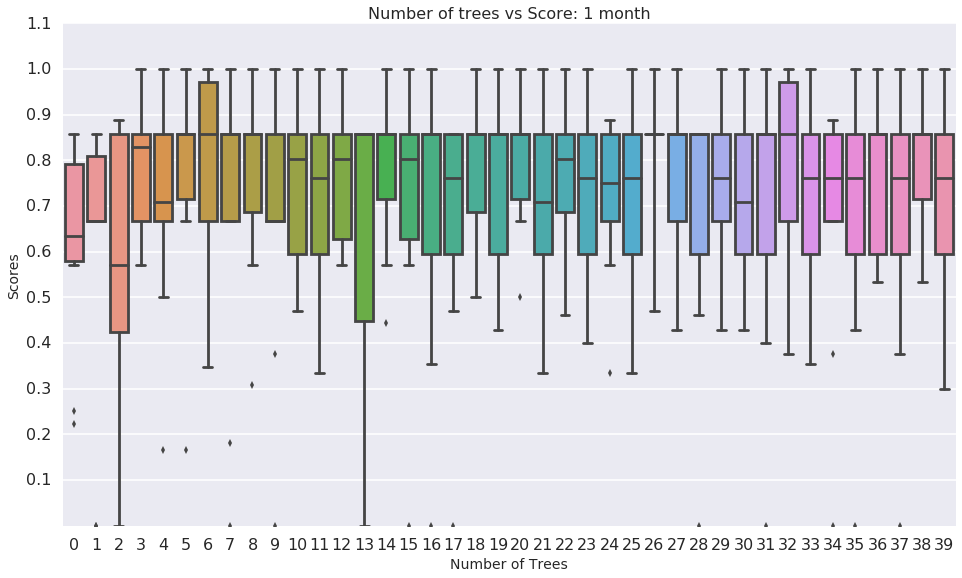

In [495]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_1m.scores,
            names = df_rf_1m.num_trees.values )

plt.title(  "Number of trees vs Score: 1 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


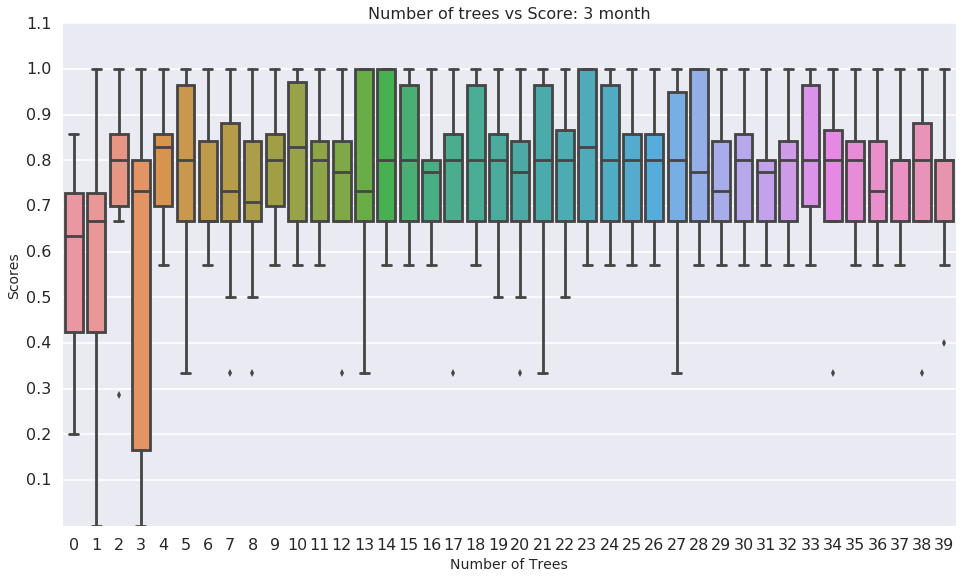

In [489]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_3m.scores,
            names = df_rf_3m.num_trees.values )

plt.title(  "Number of trees vs Score: 3 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.1, 1.2, 0.1 ) )
sns.set_context('poster')


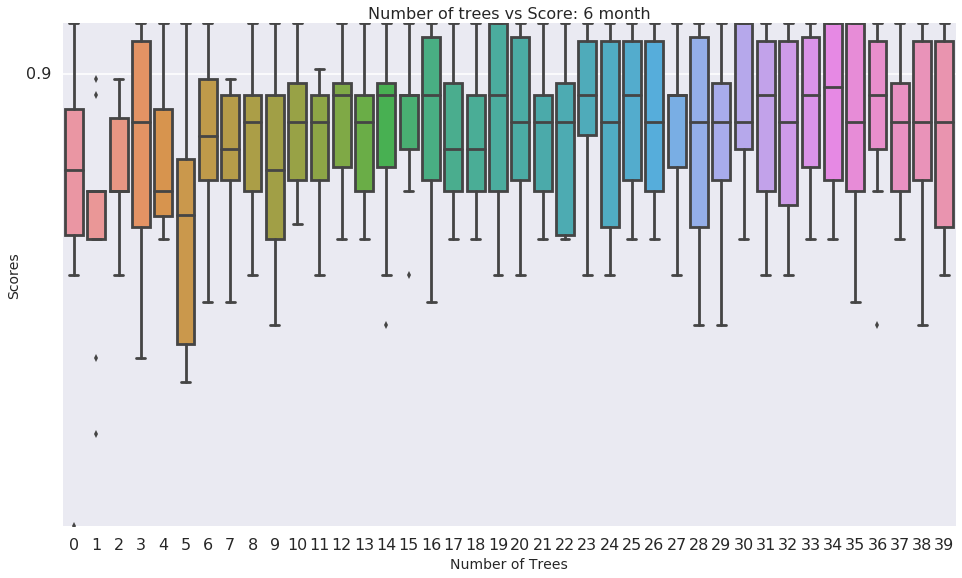

In [490]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_6m.scores,
            names = df_rf_6m.num_trees.values )

plt.title(  "Number of trees vs Score: 6 month", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


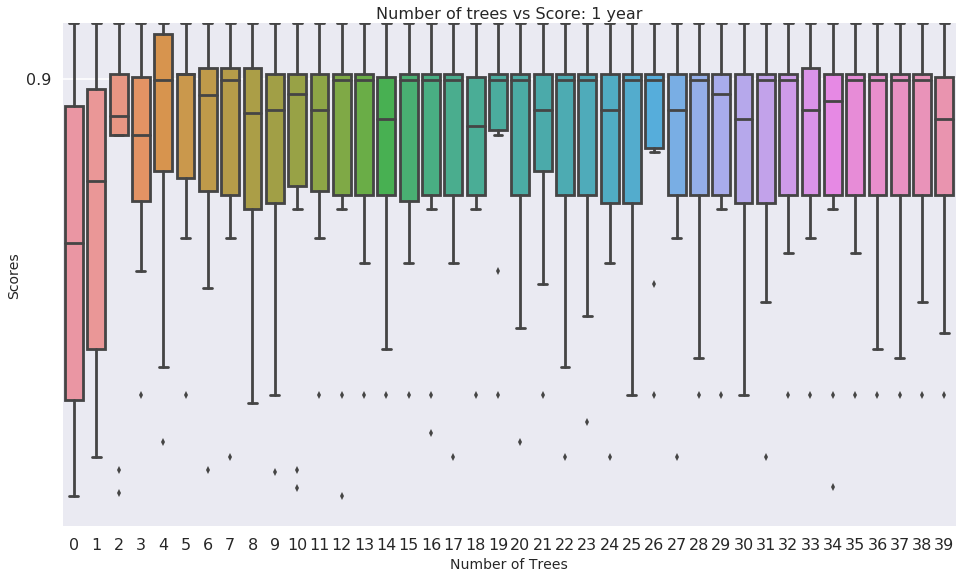

In [491]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_1y.scores,
            names = df_rf_1y.num_trees.values )

plt.title(  "Number of trees vs Score: 1 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


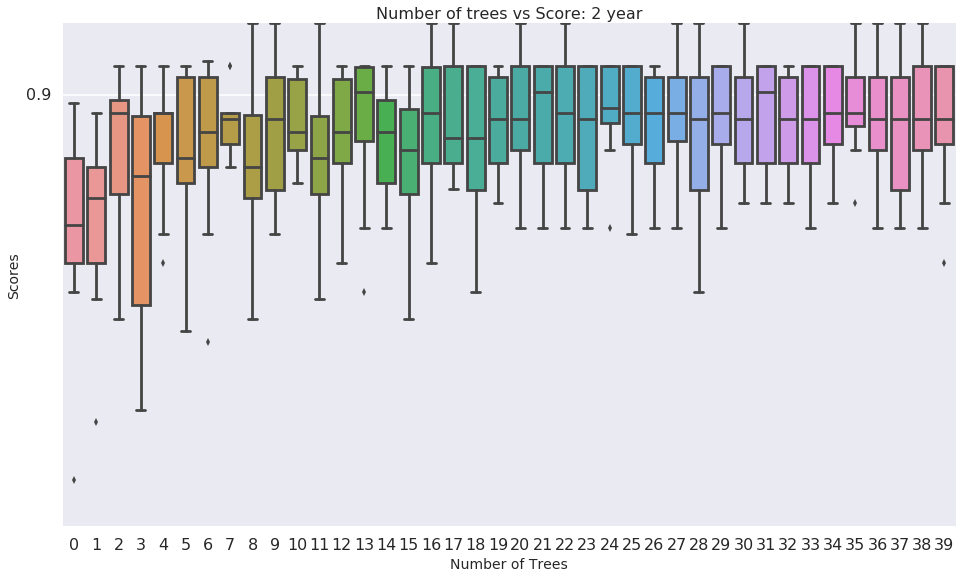

In [492]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_2y.scores,
            names = df_rf_2y.num_trees.values )

plt.title(  "Number of trees vs Score: 2 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


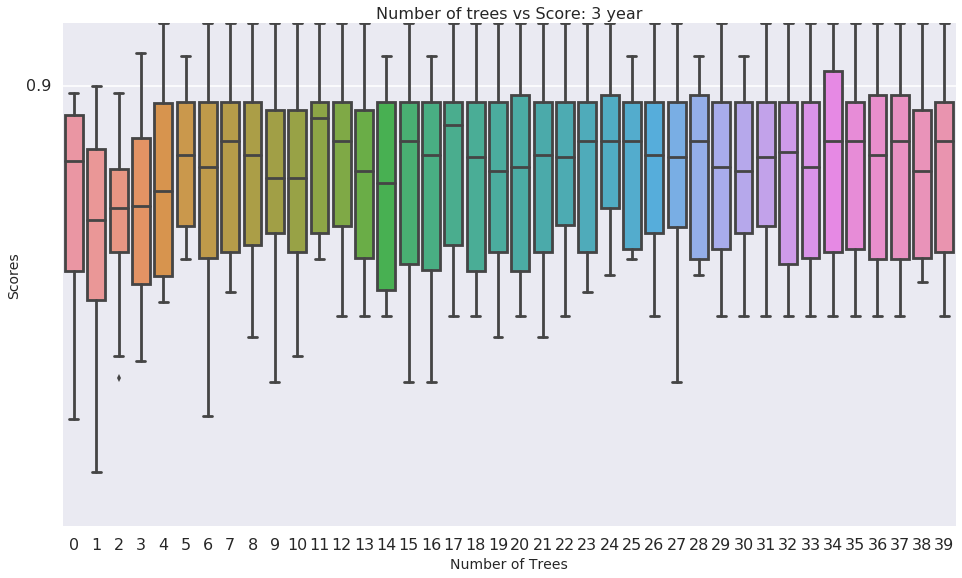

In [493]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_3y.scores,
            names = df_rf_3y.num_trees.values )

plt.title(  "Number of trees vs Score: 3 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


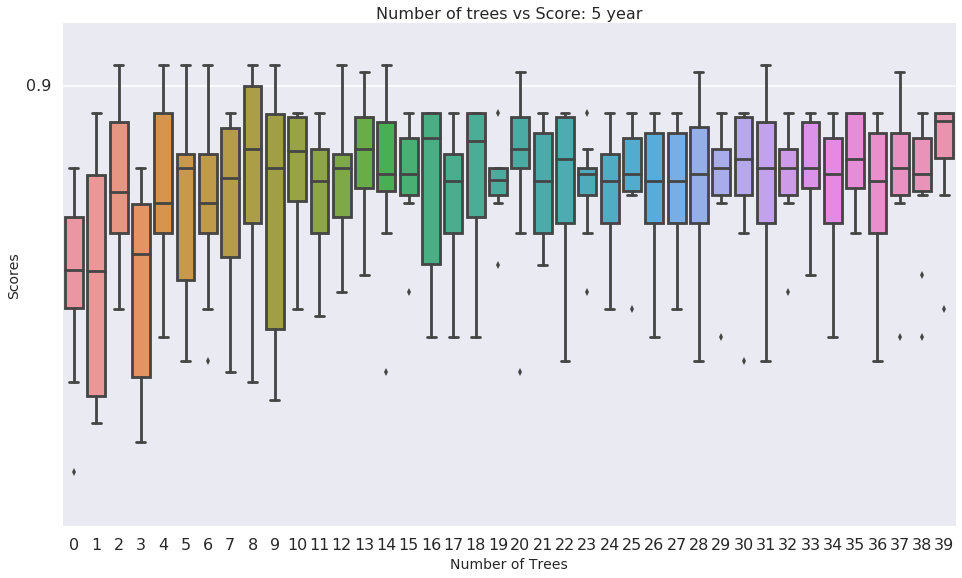

In [494]:
# plot the scores of the random forests as a function of the number of trees
plt.figure(figsize=(16,9))

# Scores of 10-fold cross-validation for random forests ranging from 1 to 40 trees as a box plot
sns.boxplot(data  = df_rf_5y.scores,
            names = df_rf_5y.num_trees.values )

plt.title(  "Number of trees vs Score: 5 year", fontsize=16)
plt.xlabel( "Number of Trees", fontsize=14)
plt.ylabel( "Scores", fontsize=14)
plt.yticks( np.arange( 0.9, 1.0, 0.1 ) )
sns.set_context('poster')


In [496]:
##
# 1 month:
##
# Train random forest classifier with the optimal 27 estimators
## 
clf_1m = sklearn.ensemble.RandomForestClassifier( n_estimators = 27)
clf_1m = clf_1m.fit( X_1m[:1000, :], Y_1m[:1000] )

##
# 3 month:
##
# Train random forest classifier with the optimal 3 estimators
## 
clf_3m = sklearn.ensemble.RandomForestClassifier( n_estimators = 3)
clf_3m = clf_3m.fit( X_3m[:1000, :], Y_3m[:1000] )

##
# 6 month:
##
# Train random forest classifier with the optimal 2 estimators
## 
clf_6m = sklearn.ensemble.RandomForestClassifier( n_estimators = 2)
clf_6m = clf_6m.fit( X_6m[:1000, :], Y_6m[:1000] )

##
# 1 year:
##
# Train random forest classifier with the optimal 20 estimators
## 
clf_1y = sklearn.ensemble.RandomForestClassifier( n_estimators = 20)
clf_1y = clf_1y.fit( X_1y[:1000, :], Y_1y[:1000] )

##
# 2 year:
##
# Train random forest classifier with the optimal 8 estimators
## 
clf_2y = sklearn.ensemble.RandomForestClassifier( n_estimators = 8)
clf_2y = clf_2y.fit( X_2y[:1000, :], Y_2y[:1000] )

##
# 3 year:
##
# Train random forest classifier with the optimal 3 estimators
## 
clf_3y = sklearn.ensemble.RandomForestClassifier( n_estimators = 3)
clf_3y = clf_3y.fit( X_3y[:1000, :], Y_3y[:1000] )

##
# 5 year:
##
# Train random forest classifier with the optimal 20 estimators
## 
clf_5y = sklearn.ensemble.RandomForestClassifier( n_estimators = 20)
clf_5y = clf_5y.fit( X_5y[:1000, :], Y_5y[:1000] )



# obtain the relative importance of the features 
feature_imp_1m = clf_1m.feature_importances_
feature_imp_3m = clf_3m.feature_importances_
feature_imp_6m = clf_6m.feature_importances_
feature_imp_1y = clf_1y.feature_importances_
feature_imp_2y = clf_2y.feature_importances_
feature_imp_3y = clf_3y.feature_importances_
feature_imp_5y = clf_5y.feature_importances_

#get column names
columns = ['Scheme Risk',
            'CRISIL Rating',
            'Fund Family AUM',
            'Scheme AUM',
            'Latest NAV',
            'Minimum Investment',
            'Last Dividend',
            'Bonus',
            'Fund Return',
            'Category Return'
          ]

# Diagnostics - Check relative importance of features
print feature_imp_1m
print feature_imp_3m
print feature_imp_6m
print feature_imp_1y
print feature_imp_2y
print feature_imp_3y
print feature_imp_5y


# Plot feature importances for each time frame
index = np.arange( len(columns) - 2 )
bar_width = 0.3
opacity = 0.5

[ 0.09282479  0.32644529  0.03007116  0.16264942  0.10900816  0.02359042
  0.          0.          0.08362599  0.17178477]
[ 0.03819964  0.23473942  0.09508032  0.08693189  0.1384061   0.00641235
  0.          0.          0.06095899  0.33927129]
[ 0.05316817  0.31008474  0.02494657  0.27854677  0.04855118  0.04869794
  0.          0.          0.11342792  0.1225767 ]
[ 0.13872949  0.05029554  0.02436907  0.09845752  0.19548184  0.02868523
  0.          0.          0.21808569  0.24589563]
[ 0.09117601  0.15681827  0.04072377  0.16006965  0.22862817  0.02336717
  0.          0.          0.1487865   0.15043047]
[ 0.09450338  0.35734424  0.02171873  0.20438698  0.10816254  0.01229654
  0.          0.          0.08950784  0.11207975]
[ 0.08517348  0.26857543  0.03617007  0.191835    0.09880103  0.02094613
  0.          0.          0.16150257  0.1369963 ]


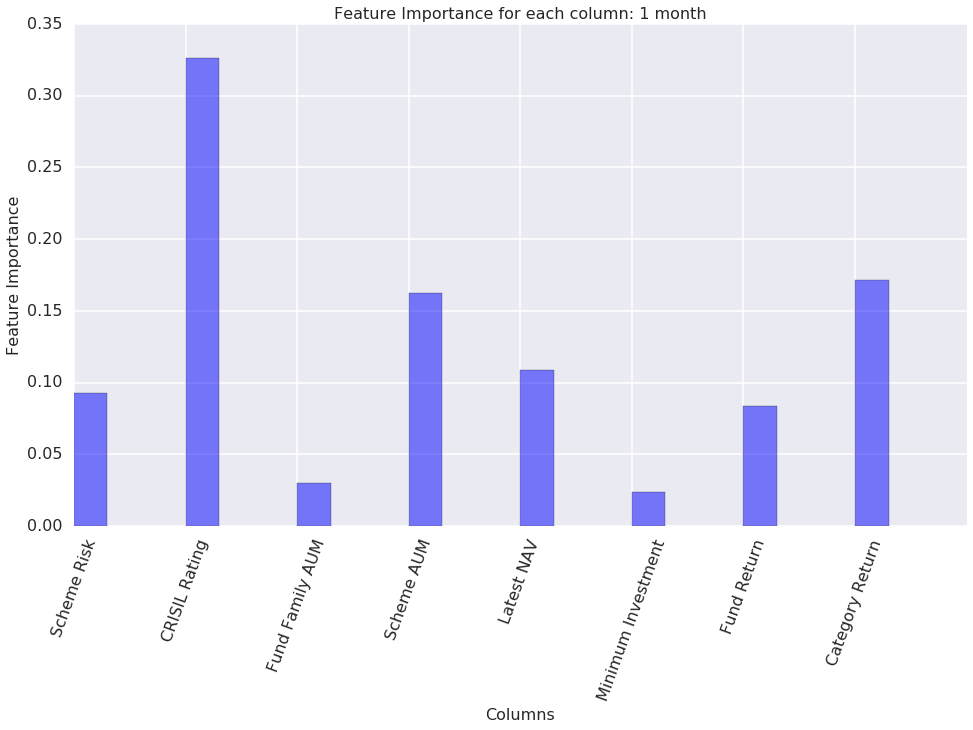

In [497]:
# 1 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_1m, [6, 7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 1 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

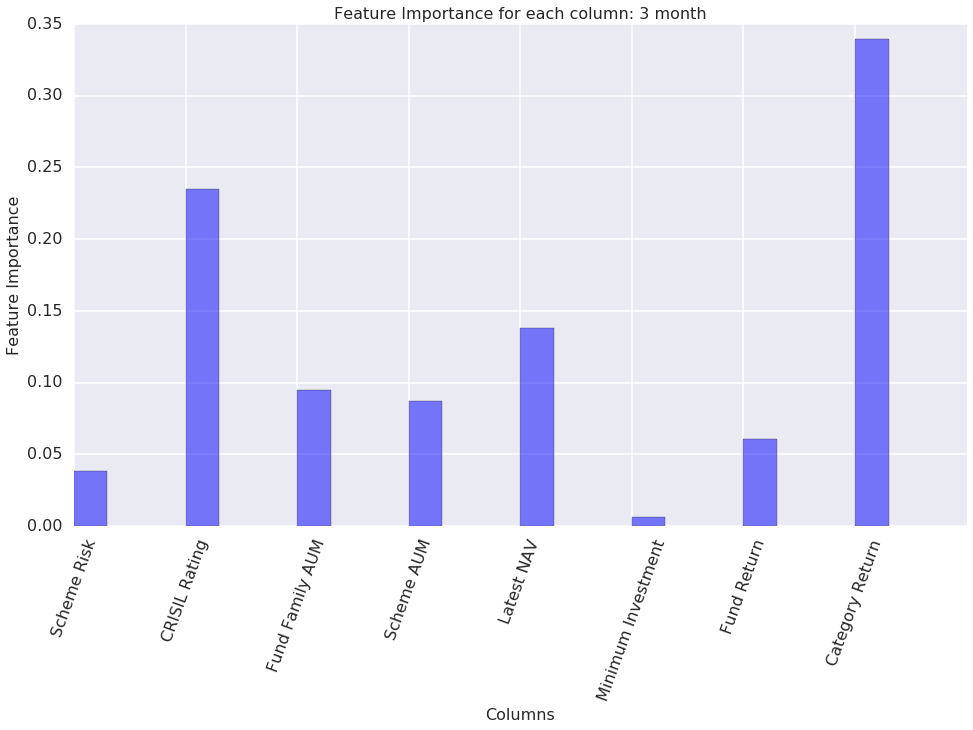

In [498]:
# 3 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_3m, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 3 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

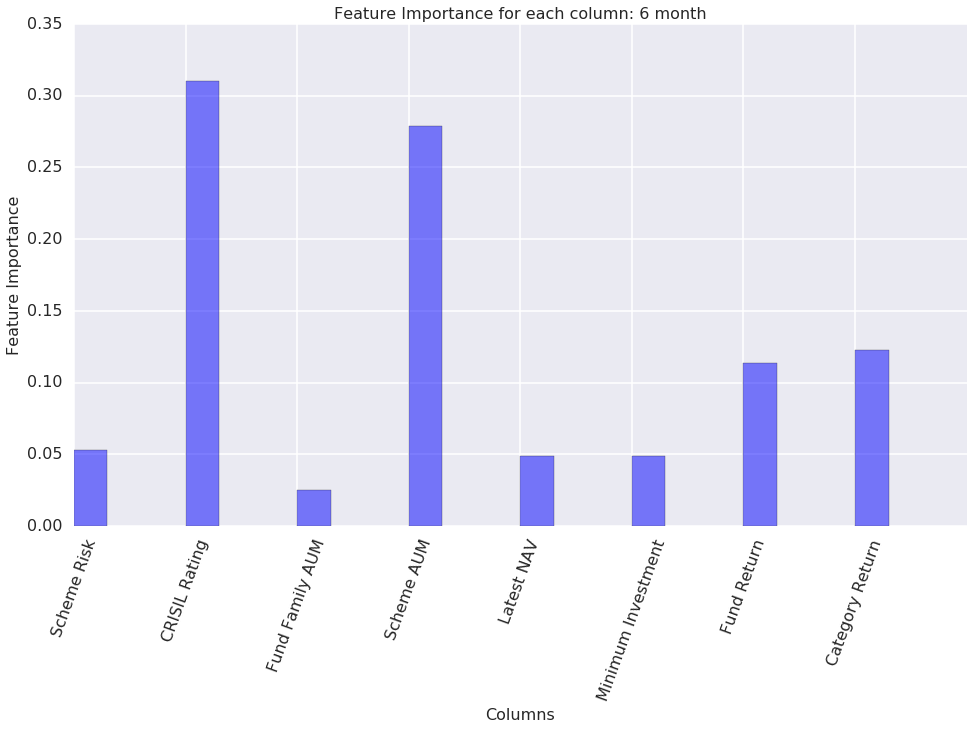

In [499]:
# 6 month
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_6m, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 6 month', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

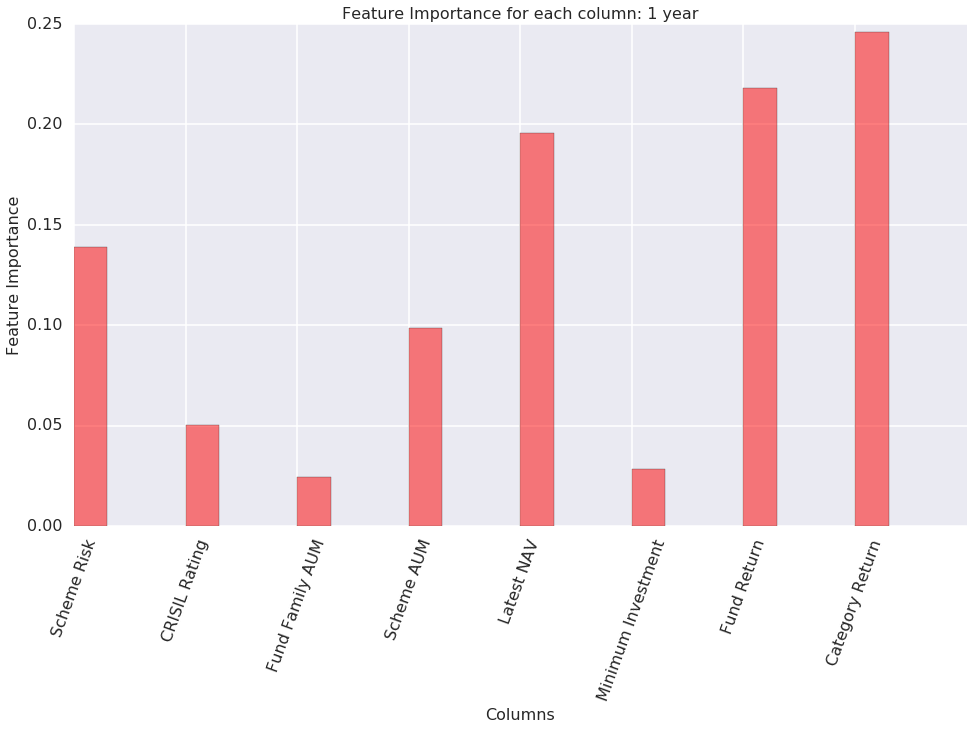

In [500]:
# 1 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_1y, [6,7]),
        bar_width,
        alpha=opacity,
        color='r',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 1 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

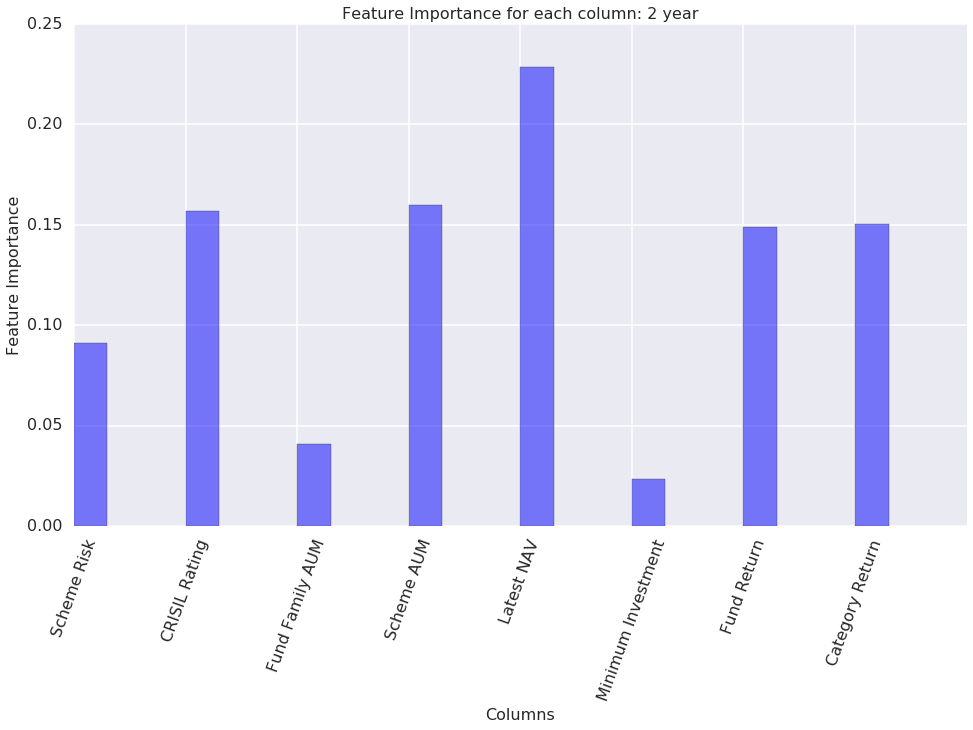

In [501]:
# 2 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_2y, [6,7]),
        bar_width,
        alpha=opacity,
        color='b',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 2 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

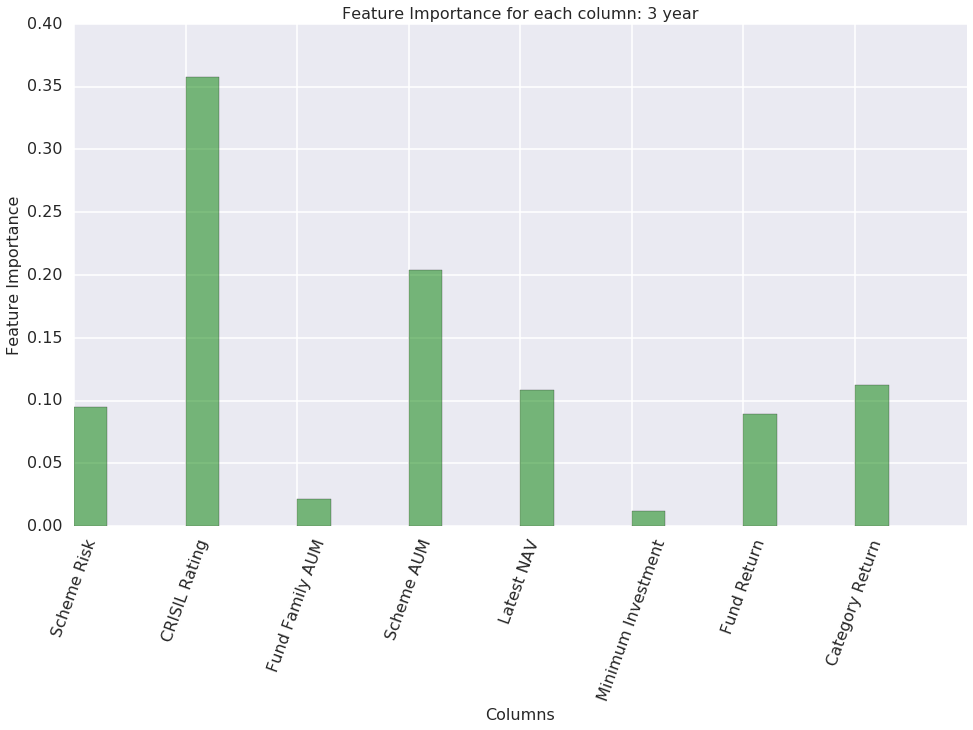

In [502]:
# 3 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_3y, [6,7]),
        bar_width,
        alpha=opacity,
        color='g',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 3 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

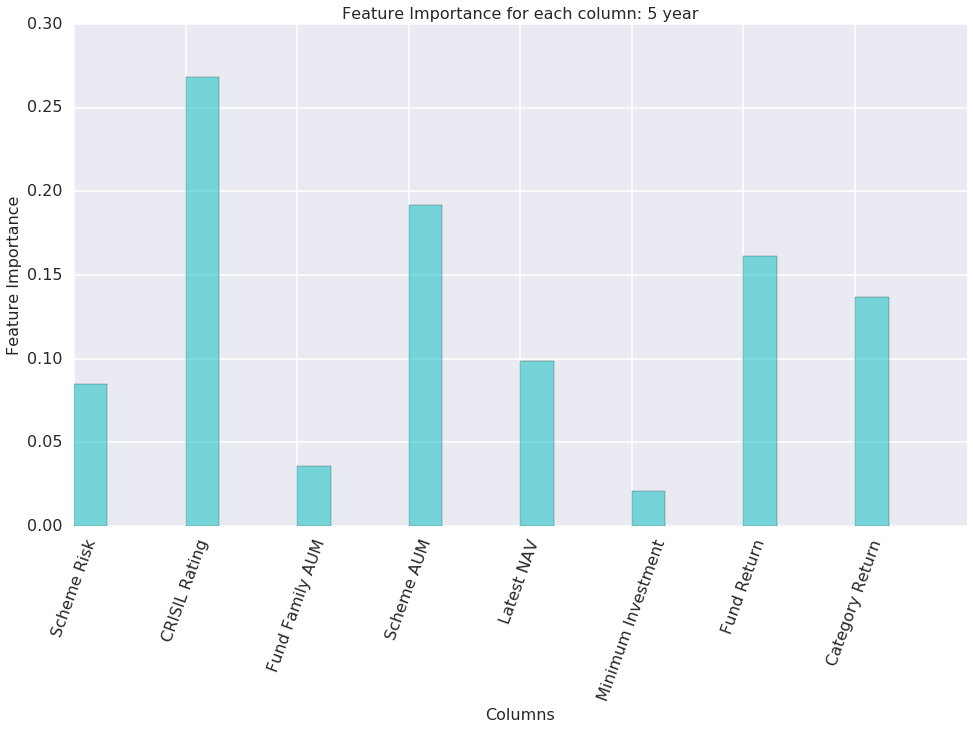

In [503]:
# 5 year
plt.figure( figsize = (16, 9) )
plt.bar(index,
        np.delete( feature_imp_5y, [6,7]),
        bar_width,
        alpha=opacity,
        color='c',
        label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column: 5 year', fontsize = 16)
plt.xticks(index, np.delete(columns, [6,7]), rotation = 70)
plt.show()

In [504]:
##
# Predict good and bad fund based on Random Forest Classification
##
Y_1m_predicted = clf_1m.predict( X_1m )
Y_3m_predicted = clf_3m.predict( X_3m )
Y_6m_predicted = clf_6m.predict( X_6m )
Y_1y_predicted = clf_1y.predict( X_1y )
Y_2y_predicted = clf_2y.predict( X_2y )
Y_3y_predicted = clf_3y.predict( X_3y )
Y_5y_predicted = clf_5y.predict( X_5y )

In [506]:
##
# Model Evaluation: Classification Score
##
clf_1m_score = clf_1m.score(X_1m[1000:, :], Y_1m[1000:], sample_weight=None)
clf_3m_score = clf_3m.score(X_3m[1000:, :], Y_3m[1000:], sample_weight=None)
clf_6m_score = clf_6m.score(X_6m[1000:, :], Y_6m[1000:], sample_weight=None)
clf_1y_score = clf_1y.score(X_1y[1000:, :], Y_1y[1000:], sample_weight=None)
clf_2y_score = clf_2y.score(X_2y[1000:, :], Y_2y[1000:], sample_weight=None)
clf_3y_score = clf_3y.score(X_3y[1000:, :], Y_3y[1000:], sample_weight=None)
clf_5y_score = clf_5y.score(X_5y[1000:, :], Y_5y[1000:], sample_weight=None)
 

[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]
[ 1.  1.  1. ...,  0.  0.  0.]
[ 0.  1.  1. ...,  0.  0.  0.]
0.966216216216
0.962837837838
0.942567567568
0.989864864865
0.966216216216
0.942567567568
0.956081081081


In [512]:
print('Timeframe: {0}\nScore: {1}\n'.format('1m', clf_1m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('3m', clf_3m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('6m', clf_6m_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('1y', clf_1y_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('2y', clf_2y_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('3y', clf_3y_score) ) 
print('Timeframe: {0}\nScore: {1}\n'.format('5y', clf_5y_score) )

Timeframe: 1m
Score: 0.966216216216

Timeframe: 3m
Score: 0.962837837838

Timeframe: 6m
Score: 0.942567567568

Timeframe: 1y
Score: 0.989864864865

Timeframe: 2y
Score: 0.966216216216

Timeframe: 3y
Score: 0.942567567568

Timeframe: 5y
Score: 0.956081081081



In [526]:
## 
# List of good funds for each time frame
## 
good_funds_1m = [ fund_schemes[k] for (k, v) in enumerate( Y_1m_predicted ) if v == 1.0 ]
good_funds_3m = [ fund_schemes[k] for (k, v) in enumerate( Y_3m_predicted ) if v == 1.0 ]
good_funds_6m = [ fund_schemes[k] for (k, v) in enumerate( Y_6m_predicted ) if v == 1.0 ]
good_funds_1y = [ fund_schemes[k] for (k, v) in enumerate( Y_1y_predicted ) if v == 1.0 ]
good_funds_2y = [ fund_schemes[k] for (k, v) in enumerate( Y_2y_predicted ) if v == 1.0 ]
good_funds_3y = [ fund_schemes[k] for (k, v) in enumerate( Y_3y_predicted ) if v == 1.0 ]
good_funds_5y = [ fund_schemes[k] for (k, v) in enumerate( Y_5y_predicted ) if v == 1.0 ]



In [542]:
good_funds_1m_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_1m]

good_funds_3m_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_3m]

good_funds_6m_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_6m]

good_funds_1y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_1y]

good_funds_2y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_2y]

good_funds_3y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_3y]

good_funds_5y_sort = [ [ fund['scheme_name'], fund[ 'num_fund_ret_1m' ], fund[ 'num_fund_ret_3m' ], fund[ 'num_fund_ret_6m' ], fund[ 'num_fund_ret_1y' ], fund[ 'num_fund_ret_2y' ], fund[ 'num_fund_ret_3y' ], fund[ 'num_fund_ret_5y' ], fund[ 'scheme_url' ] ] for fund in good_funds_5y]


In [544]:
    good_funds_1m_sort.sort(key = lambda x: x[1], reverse=True)
    good_funds_3m_sort.sort(key = lambda x: x[2], reverse=True)
    good_funds_6m_sort.sort(key = lambda x: x[3], reverse=True)
    good_funds_1y_sort.sort(key = lambda x: x[4], reverse=True)
    good_funds_2y_sort.sort(key = lambda x: x[5], reverse=True)
    good_funds_3y_sort.sort(key = lambda x: x[6], reverse=True)
    good_funds_5y_sort.sort(key = lambda x: x[7], reverse=True)

    print( '## Top 5 funds for a timeframe of 1 month:')
    print( good_funds_1m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 3 months:')
    print( good_funds_3m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 6 months:')
    print( good_funds_6m_sort[:5] )

    print( '## Top 5 funds for a timeframe of 1 year:')
    print( good_funds_1y_sort[:5] )

    print( '## Top 5 funds for a timeframe of 2 years:')
    print( good_funds_2y_sort[:5] )

    print( '## Top 5 funds for a timeframe of 3 years:')
    print( good_funds_3y_sort[:5] )

    print( '## Top 5 funds for a timeframe of 5 years:')
    print( good_funds_5y_sort[:5] )

## Top 5 funds for a timeframe of 1 month:
[[u'UTI Infrastructure Fund (G)', 8.5, -6.0, -11.2, -16.8, 11.3, 11.6, 2.2, 'http://www.moneycontrol.com/mutual-funds/nav/uti-infrastructure-fund/MUT065'], [u'HDFC Tax Saver (G)', 7.9, -4.5, -7.2, -12.5, 12.3, 15.6, 8.5, 'http://www.moneycontrol.com/mutual-funds/nav/hdfc-tax-saver/MZU017'], [u'UTI Dividend Yield Fund (G)', 7.0, -1.9, -4.7, -8.8, 10.3, 11.3, 6.2, 'http://www.moneycontrol.com/mutual-funds/nav/uti-dividend-yield-fund/MUT070'], [u'IDFC Sterling Equity Fund - RP (G)', 5.4, -8.7, -7.2, -13.9, 18.2, 17.2, 12.0, 'http://www.moneycontrol.com/mutual-funds/nav/idfc-sterling-equity-fund-regular-plan/MAG162'], [u'UTI Opportunities Fund (G)', 5.3, -1.9, -7.0, -12.9, 9.7, 12.8, 9.5, 'http://www.moneycontrol.com/mutual-funds/nav/uti-opportunities-fund/MUT072']]
## Top 5 funds for a timeframe of 3 months:
[[u'ICICI Pru Long Term Gilt (G)', 3.7, 3.3, 2.5, 5.7, 12.8, 8.2, 8.4, 'http://www.moneycontrol.com/mutual-funds/nav/icici-prudential-long-t

In [550]:
# Demonstrate class imbalance

# Print the number of good samples
print( sum(Y_1m[1000:]), sum(Y_3m), sum(Y_6m), sum(Y_1y), sum(Y_2y), sum(Y_3y), sum(Y_5y))

# Print the number of total samples
print( len(Y_1m[1000:]), len(Y_3m), len(Y_6m), len(Y_1y), len(Y_2y), len(Y_3y), len(Y_5y))


(12.0, 52.0, 61.0, 72.0, 120.0, 139.0, 107.0)
(296, 1296, 1296, 1296, 1296, 1296, 1296)
